### Install and set up libraries

In [1]:
!pip install astropy
!pip install sep

In [2]:
from astropy.io import fits
import sep
import matplotlib.pyplot as plt
import numpy as np

### rcParams customizes/modifies the default settings for plots
##### rcParams is a dictionary-like object; each key is associated to a specific plot property

In [3]:
from matplotlib import rcParams

### %matplotlib inline: A magic command in Jupyter Notebook
##### Magic commands usually begin with %
##### This magic command instructs Jupyter Notebook to display static Matplotlib plots in the notebook (and not in a separate window), right below the cell that generates the plot

In [4]:
%matplotlib inline

### rcParams['figure.figsize'] changes default size of the figures
### rcParams['font.size'] changes the font size of text

In [5]:
rcParams['figure.figsize'] = [10., 8.]
rcParams['font.size'] = 8

### The object 'hdulist' will hold the contents of the FITS file
##### To be specific, 'hdulist' contains HDU's (Headers and Data Unit List) in the FITS file and their HDU types, dimensions, and data types
##### The image data is stored in the first HDU/index.
##### This data can be accessed using the '.data' attribute
##### The variable 'image_data' stores a 2D array containing the image data from the FITS file

In [6]:
with fits.open('./image.fits') as hdulist:
    image_data = hdulist[0].data



ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992                [astropy.io.fits.card]
ESO-LOG 00:00:00> DATE         = '1992-10-26'  / Mon Oct 26, 1992               
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC       [astropy.io.fits.card]
ESO-LOG 03:04:08>-START EXPO EMMI RED          / Start exp. on EMMI Red CC      
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:04:09> EXPO EMMI RED NO = 24887     / Exp. num. on EMMI Red CCD      
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD       [astropy.io.fits.card]
ESO-LOG 03:10:52>-STOP EXPO EMMI RED           / Stop exp. on EMMI Red CCD      


### Get the mean and standard deviation of the image data

In [7]:
mean, standard_deviation = np.mean(image_data), np.std(image_data)

### plt.imshow() displays the image data as a 2D grid of colored pixels
##### Each value in the image data is associated to the brightness of a pixel in the image
##### Interpolation argument is set to 'nearest', which essentially means the values in the image data will remain the same
##### cmap argument specifies the colormap used to map pixel values, or image data values, to colors, which will be shades of gray
##### vmin and vmax arguments set the minimum and maximum pixel values displayed in the image, which specifies the range of contrast used; the minimum pixel value will be the mean of the image data values subtracted by the standard deviation of the image data values while the maximum pixel value will be the mean of the image data values added by the standard deviation of the image data values. This range ensures the display focuses on a manageable range.
##### Origin argument places the origin at the bottom left of the image

### plt.colorbar() displays a colorbar next to the 2D pixel grid, which indicates the range of pixel values from the minimum to maximum (vmin to vmax)

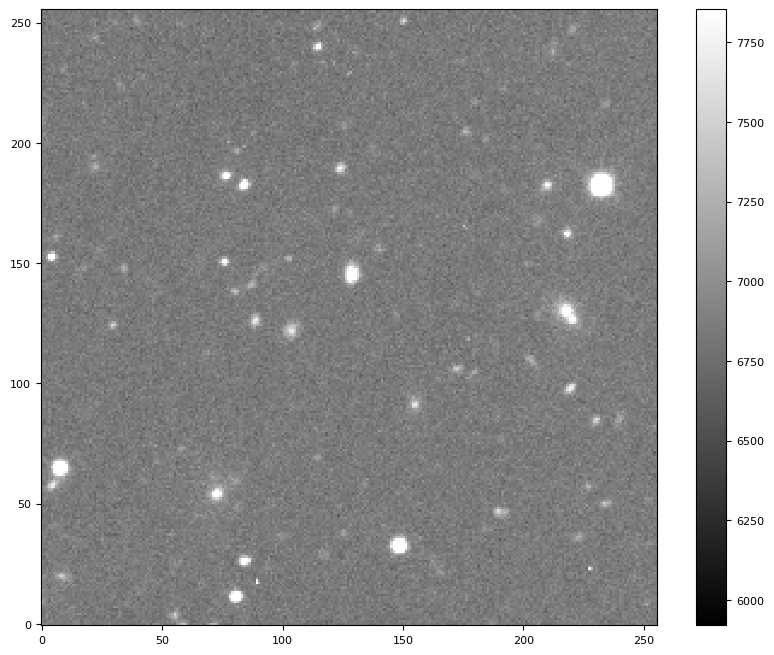

In [8]:
plt.imshow(image_data, interpolation='nearest', cmap='gray', vmin=mean - standard_deviation, vmax=mean + standard_deviation, origin='lower')
plt.colorbar()

plt.savefig('original_image.png')

### sep.Background(image_data) employs background estimation on the image data
##### The 'background' in background estimation refers to the faint glow or noise patterns seen in the 2D grid, which are not objects that I am interested in detecting (because they are not stars, galaxies, etc.). Without subtracting these faint objects, object detection may identify every glowing object in the image, which I don't prefer
##### The result of this function returns a Background object, which holds a 2D array where each pixel value is associated to the estimated average brightness of the background noise (bkg.back) and a different 2D array that gives the variation of the estimated brightness of the background noise (bkg.rms)
##### The Background object also holds the value of the 'global' mean of the pixel values in bkg.back and the average variation of the values in bkg.rms
##### Subtracting the 2D array of the image data with the 2D array from bkg.back will provide a new array that excludes the noise patterns, which will be noticeable when displaying the 2D grid of colored pixels.

6852.04931640625
65.46174621582031


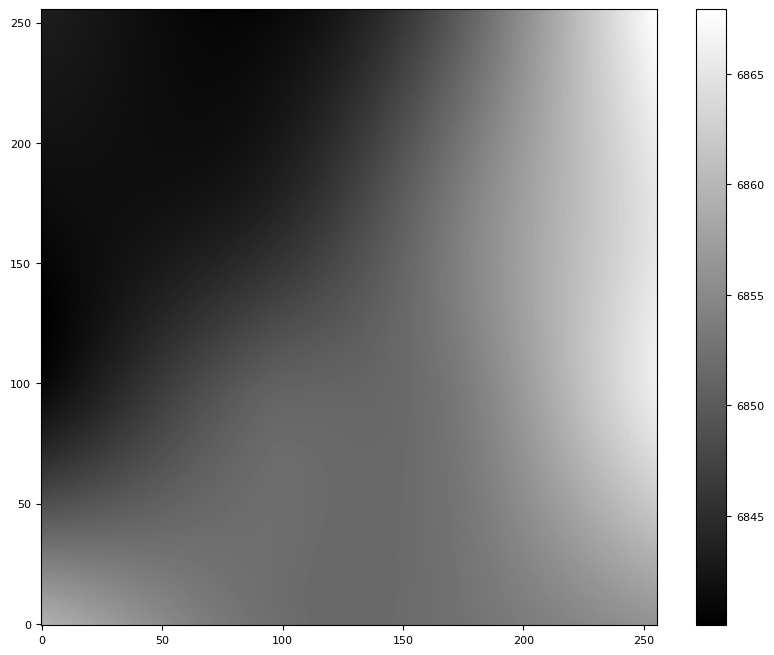

In [9]:
background = sep.Background(image_data)

print(background.globalback)
print(background.globalrms)

background_image = background.back()

plt.imshow(background_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

plt.savefig('background_image.png')

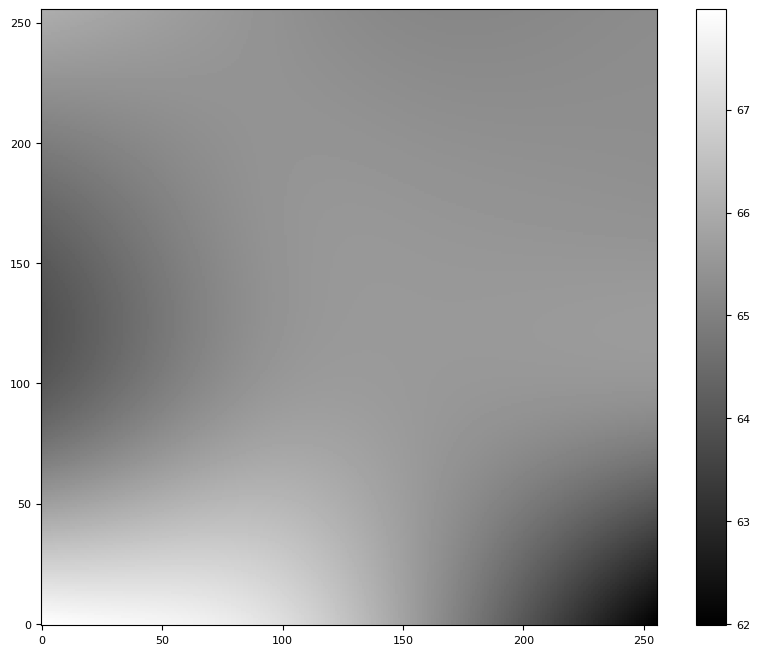

In [10]:
background_rms = background.rms()

plt.imshow(background_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

plt.savefig('background_rms.png')

In [11]:
subtracted_image_data = image_data - background_image

### sep.extract() performs object detection on the 2D array subtracted_image_data
##### The function compares each pixel value in the array to the detection threshold (1.5 * err); err is background.rms() while the reason 1.5 is used is because there is a flat variance of the estimated brightness of the background noise as seen from the displayed image above. Due to this finding, the detection process is more reliable, allowing an increased risk by raising the number from 1.0 to detect more objects that may be faint-appearing stars or galaxies, but may also lead to detecting a few objects that aren't stars or galaxies.
##### Groups of pixel values that are next to each other and are greater than the detection process would be considered a found object that is likely to not be noise.
##### Every group of pixels that are found as an object and not noise due to its brightness would would have its properties be calculated. These properties can be found in the array variable called objects, which contains many fields about the discovered objects.

In [12]:
objects = sep.extract(subtracted_image_data, 1.5, err=background.globalrms)

### Import a patch from Matplotlib called Ellipse, which will overlay the displayed 2D grid of colored pixels below with its distinguishable red hue

In [13]:
from matplotlib.patches import Ellipse

### Display the subtracted image data as a 2D grid of colored pixels
### The mean and standard deviation of the pixel values in the array will also be calculated

### For each found object, the Ellipse that will overlay the found object on the image will be centered at the center of the found object (x and y coordinates of its center), the size of the Ellipse will be 6 times bigger than the size of the found object, and rotates the ellipse in accordance to the angle of the object
##### Only the outline of the ellipse will be colored
##### Ultimately, each ellipse will be added to the plot during each iteration

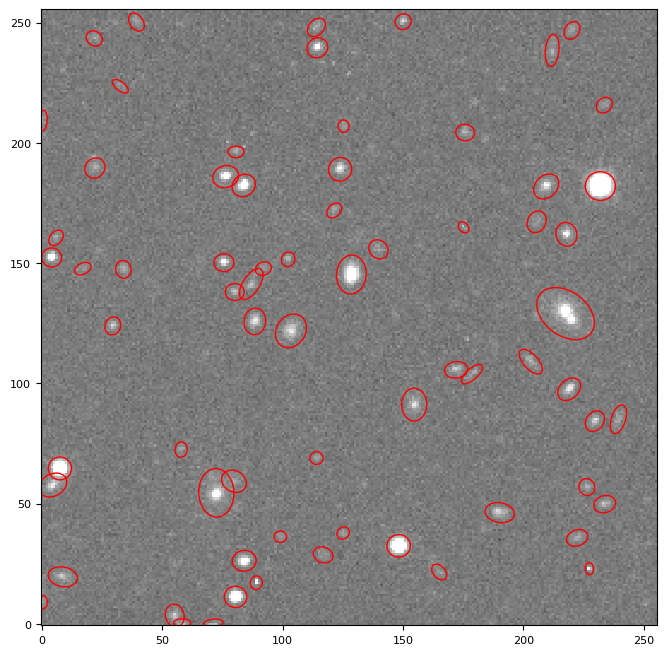

In [14]:
fig, ax = plt.subplots()
mean, standard_deviation = np.mean(subtracted_image_data), np.std(subtracted_image_data)
image = ax.imshow(subtracted_image_data, interpolation='nearest', cmap='gray',
               vmin=mean-standard_deviation, vmax=mean+standard_deviation, origin='lower')

for i in range(len(objects)):
    ellipse = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=7*objects['a'][i],
                height=7*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    ellipse.set_facecolor('none')
    ellipse.set_edgecolor('red')
    ax.add_artist(ellipse)

plt.savefig('subtracted_image_data.png')

### sep.sum_circle() computes the total brightness (flux) within a circle of a found object, which each can be located by its coordinates, with a radius of 3.
##### The uncertainty in the measured flux will also be calculated, which is dependent on the background noise (bkg.globalrms) and the random photon noise (gain)

In [15]:
flux, fluxerr, flag = sep.sum_circle(subtracted_image_data, objects['x'], objects['y'],
                                     3.0, err=background.globalrms, gain=1.0)

for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i+1, flux[i], fluxerr[i]))

object 1: flux = 2249.159297 +/- 291.027802
object 2: flux = 3092.220430 +/- 291.592204
object 3: flux = 5949.868379 +/- 356.562003
object 4: flux = 1851.426582 +/- 295.028816
object 5: flux = 72736.386914 +/- 440.172206
object 6: flux = 3860.756152 +/- 352.163162
object 7: flux = 6418.913789 +/- 357.458973
object 8: flux = 2210.707656 +/- 350.791223
object 9: flux = 2741.607227 +/- 352.277746
object 10: flux = 20916.875566 +/- 376.966138


### Repeating the exact same code for this new FITS file; exact code being steps taken after opening the FITS file 'image.fits'

##### Added the code f105w_band_image_data.byteswap().newbyteorder() due to a ValueError. According to the tutorials, it is also recommended to create different variable names for similar code due to potential errors.

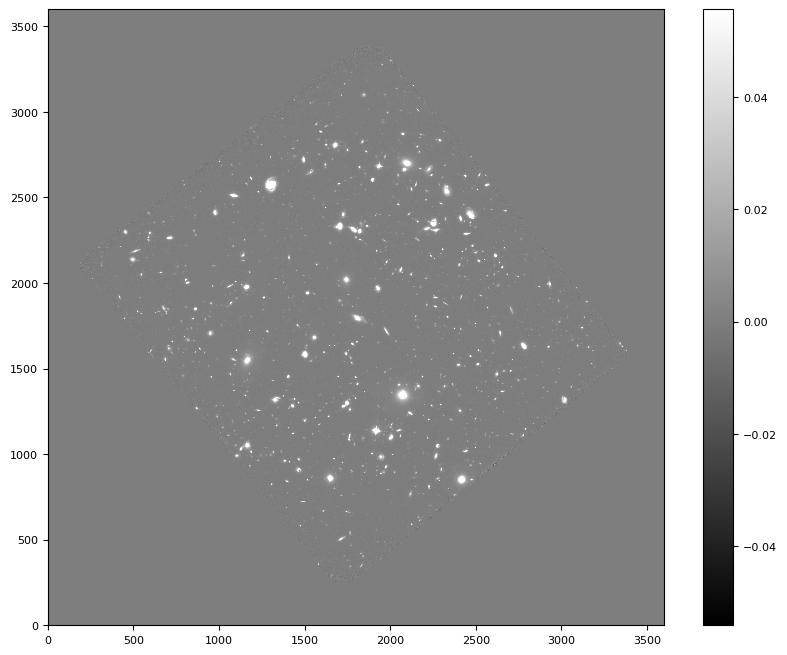

In [16]:
with fits.open('./hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits') as hdulist:
    f105w_band_image_data = hdulist[0].data
    f105w_band_image_data = f105w_band_image_data.byteswap().newbyteorder()

mean, standard_deviation = np.mean(f105w_band_image_data), np.std(f105w_band_image_data)

plt.imshow(f105w_band_image_data, interpolation='nearest', cmap='gray', vmin=mean - standard_deviation, vmax=mean + standard_deviation, origin='lower')
plt.colorbar()

plt.savefig('original_f105w_band_image.png')

0.0
0.0005398219218477607


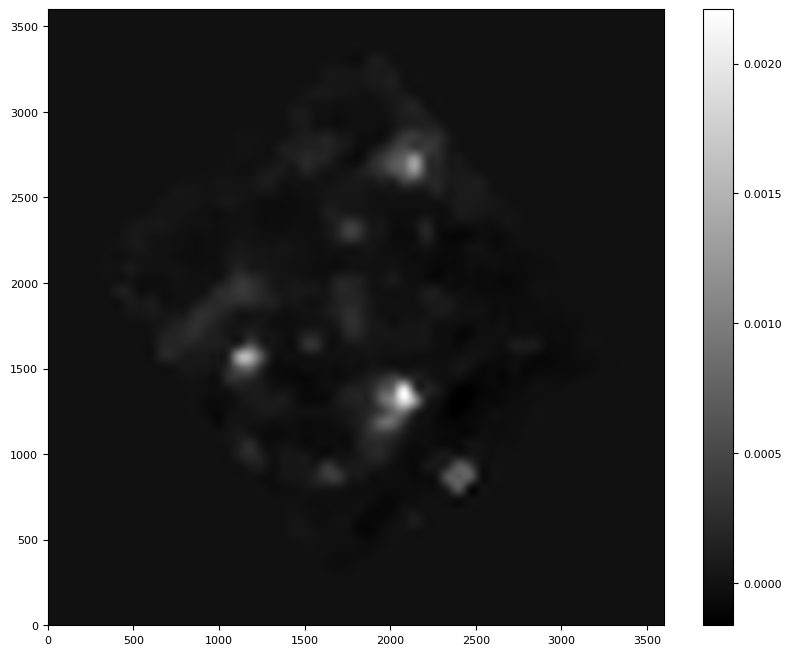

In [17]:
background = sep.Background(f105w_band_image_data)

print(background.globalback)
print(background.globalrms)

background_image = background.back()

plt.imshow(background_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

plt.savefig('background_f105w_band_image.png')

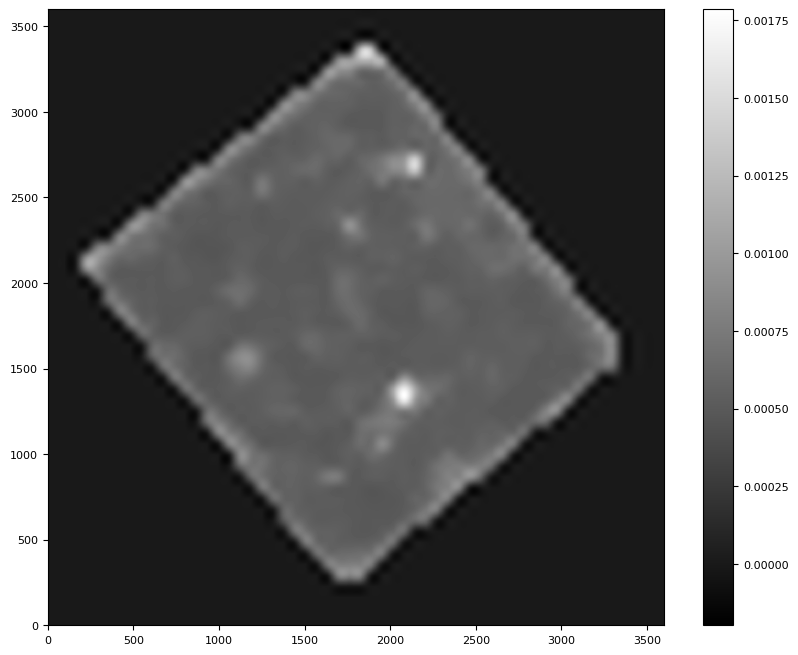

In [18]:
background_rms = background.rms()

plt.imshow(background_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar()

plt.savefig('background_rms_f105w_band_image.png')

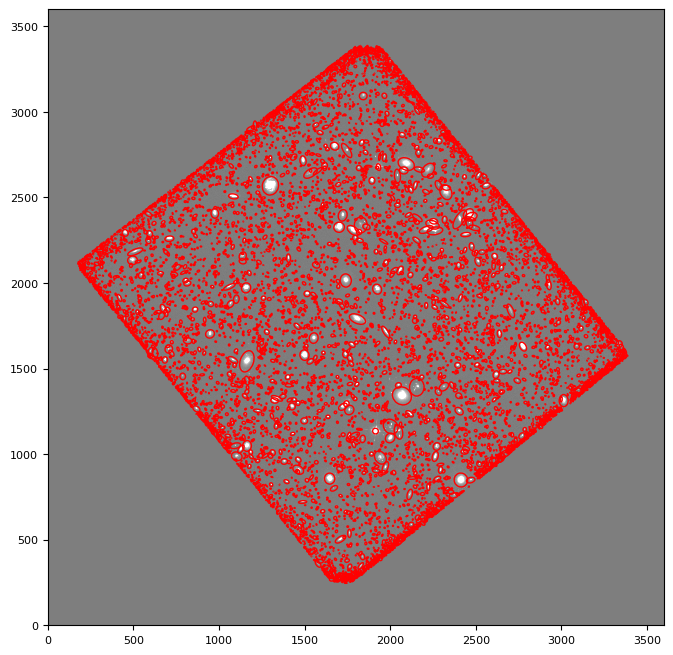

In [19]:
subtracted_image_data = f105w_band_image_data - background_image

objects = sep.extract(subtracted_image_data, 1.5, err=background.globalrms)

fig, ax = plt.subplots()
mean, standard_deviation = np.mean(subtracted_image_data), np.std(subtracted_image_data)
image = ax.imshow(subtracted_image_data, interpolation='nearest', cmap='gray',
               vmin=mean-standard_deviation, vmax=mean+standard_deviation, origin='lower')

for i in range(len(objects)):
    ellipse = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    ellipse.set_facecolor('none')
    ellipse.set_edgecolor('red')
    ax.add_artist(ellipse)

plt.savefig('subtracted_f105w_band_image_data.png')

In [20]:
flux, fluxerr, flag = sep.sum_circle(subtracted_image_data, objects['x'], objects['y'],
                                     3.0, err=background.globalrms, gain=1.0)

for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i+1, flux[i], fluxerr[i]))

object 1: flux = 0.031282 +/- 0.176890
object 2: flux = 0.031018 +/- 0.176142
object 3: flux = -0.024388 +/- 0.002883
object 4: flux = 0.001947 +/- 0.044219
object 5: flux = 0.012457 +/- 0.111649
object 6: flux = -0.011228 +/- 0.002875
object 7: flux = 0.029368 +/- 0.171394
object 8: flux = -0.009126 +/- 0.002875
object 9: flux = 0.048023 +/- 0.219161
object 10: flux = 0.027840 +/- 0.166877


### The number of sources can be found by inputting the array variable 'objects' in the len() function

In [21]:
print(f'The number of sources found in the image is {len(objects)}')

The number of sources found in the image is 8643


### Displaying a histogram of all the fluxes

##### The operation -2.5 * np.log10(flux) is used to correctly display the distribution of fluxes into the histogram. This operation is commonly used to represent the brightness of fluxes.

<ipython-input-22-45e9397994dc>:1: RuntimeWarning: invalid value encountered in log10
  m_f105w = -2.5 * np.log10(flux)


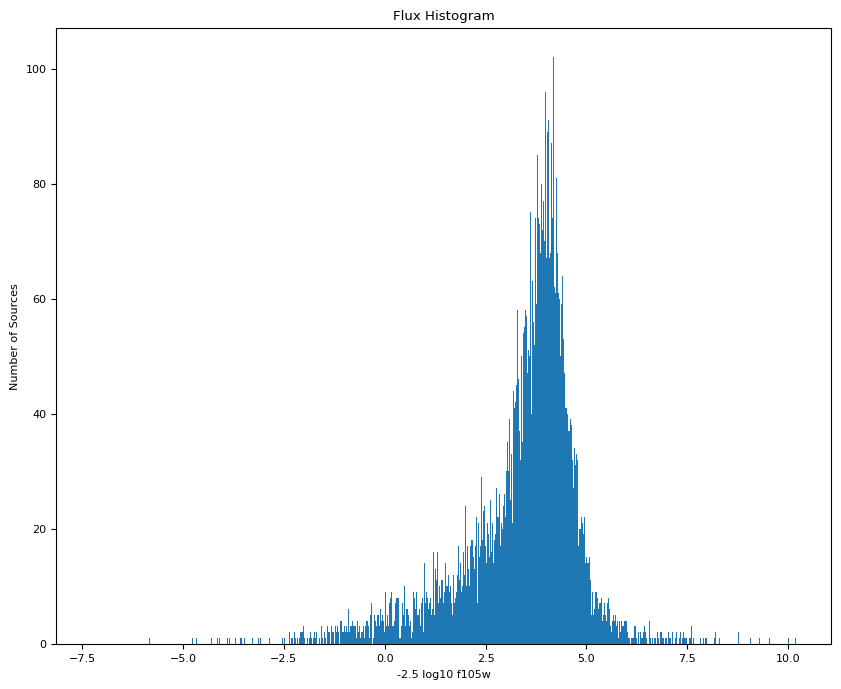

In [22]:
m_f105w = -2.5 * np.log10(flux)

plt.hist(m_f105w, bins=1000)

plt.xlabel('-2.5 log10 f105w')
plt.ylabel('Number of Sources')
plt.title('Flux Histogram')

plt.show()

### Finding and printing the mean, median, and standard deviation of the fluxes

In [23]:
print(f'The mean of the fluxes is {np.mean(flux)}')
print(f'The median of the fluxes is {np.median(flux)}')
print(f'The standard deviation of the fluxes is {np.std(flux)}')

The mean of the fluxes is 0.3617466258281149
The median of the fluxes is 0.030954822942148894
The standard deviation of the fluxes is 9.241925555851745


### Finding the largest outlier in the distribution of fluxes, identifying it in the subtracted image with an Ellipse, and calculating how many standard deviations is the outlier away from the mean.

##### I printed out all the properties of objects to check the names of each one I can access, I compared the value between the array variable flux and objects just to ensure if each flux is associated with the corresponding object in order.

In [24]:
print(objects.dtype.names)

('thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y', 'x2', 'y2', 'xy', 'errx2', 'erry2', 'errxy', 'a', 'b', 'theta', 'cxx', 'cyy', 'cxy', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak', 'xpeak', 'ypeak', 'flag')


The largest outlier in the distribution of fluxes is 807.2972835731507
8643 8643


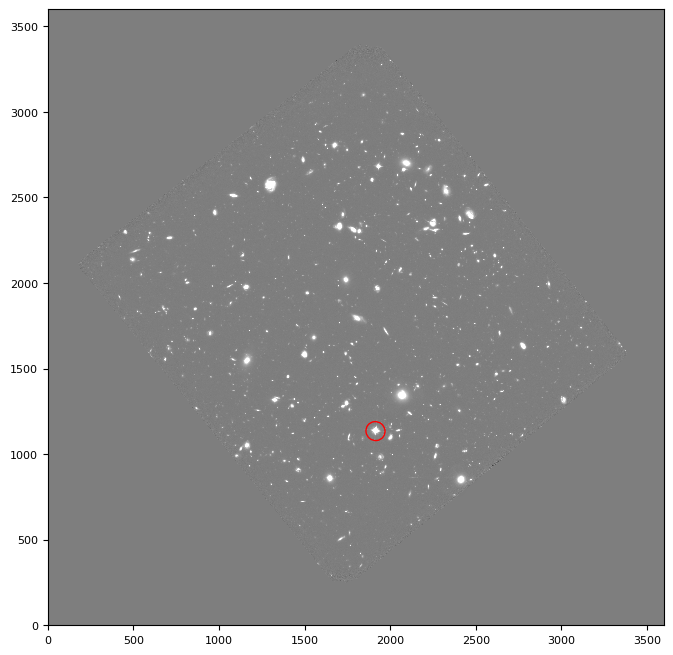

In [25]:
outlier = np.max(flux)
print(f'The largest outlier in the distribution of fluxes is {outlier}')

fig, ax = plt.subplots()
outlier_image = ax.imshow(subtracted_image_data, interpolation='nearest', cmap='gray',
               vmin=mean-standard_deviation, vmax=mean+standard_deviation, origin='lower')

print(len(flux), len(objects))
for i in range(len(flux)):
    if flux[i] == outlier:
        outlier_ellipse = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=20*objects['a'][i],
                height=20*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
        outlier_ellipse.set_facecolor('none')
        outlier_ellipse.set_edgecolor('red')
        ax.add_artist(outlier_ellipse)

In [26]:
num_std_away_from_mean = 0
reducing_outlier = outlier
print(reducing_outlier)
while reducing_outlier > np.mean(flux):
    reducing_outlier -= np.std(flux)
    num_std_away_from_mean += 1

print(f'The largest outlier is {num_std_away_from_mean} standard deviations away from the mean')

807.2972835731507
The largest outlier is 88 standard deviations away from the mean


### Making a 3-color false image using RGB from the f105w, f125w, and f160w band images

##### Accesses the image data from the f125w and f160w FITS files

##### Rescales the pixel values from all the different array variables using a logarithmic transformation, which will enhance faint parts in the output image. The range of pixel values displayed in the output image will be limited between the minimum and maximum values created from the rescaling process. Multiple variables will store the rescaled data and the minimum and maximum values respectively.

###### Any rescaled pixel values that are below the calculated minimum value will be set to that minimum value. Similarly, any rescaled pixel values that are above the calculated maximum value will be set to that maximum value. This limitation will help ensure that the combined output image will be in an aligned range that will be recalculated again later to properly create the RGB image.

##### The variable 'color_false_image' is a 3D Numpy array that stores each updated image data array into a color channel. The f160w data is assigned to the red channel, the f125w is assigned to the green channel, and the f105w is assigned to the blue channel

##### Before the image data are assigned to each color channel, they will be recalculated again to be within the range between 0 and 1, which represents the intensity of the color and the range colored channels allow.

##### Saves the image as a png, makes sure that all of the visible elements are encompassed into the downloaded image, no extra white spaces can be seen around the downloaded plot, and the resolution or dpi is 600

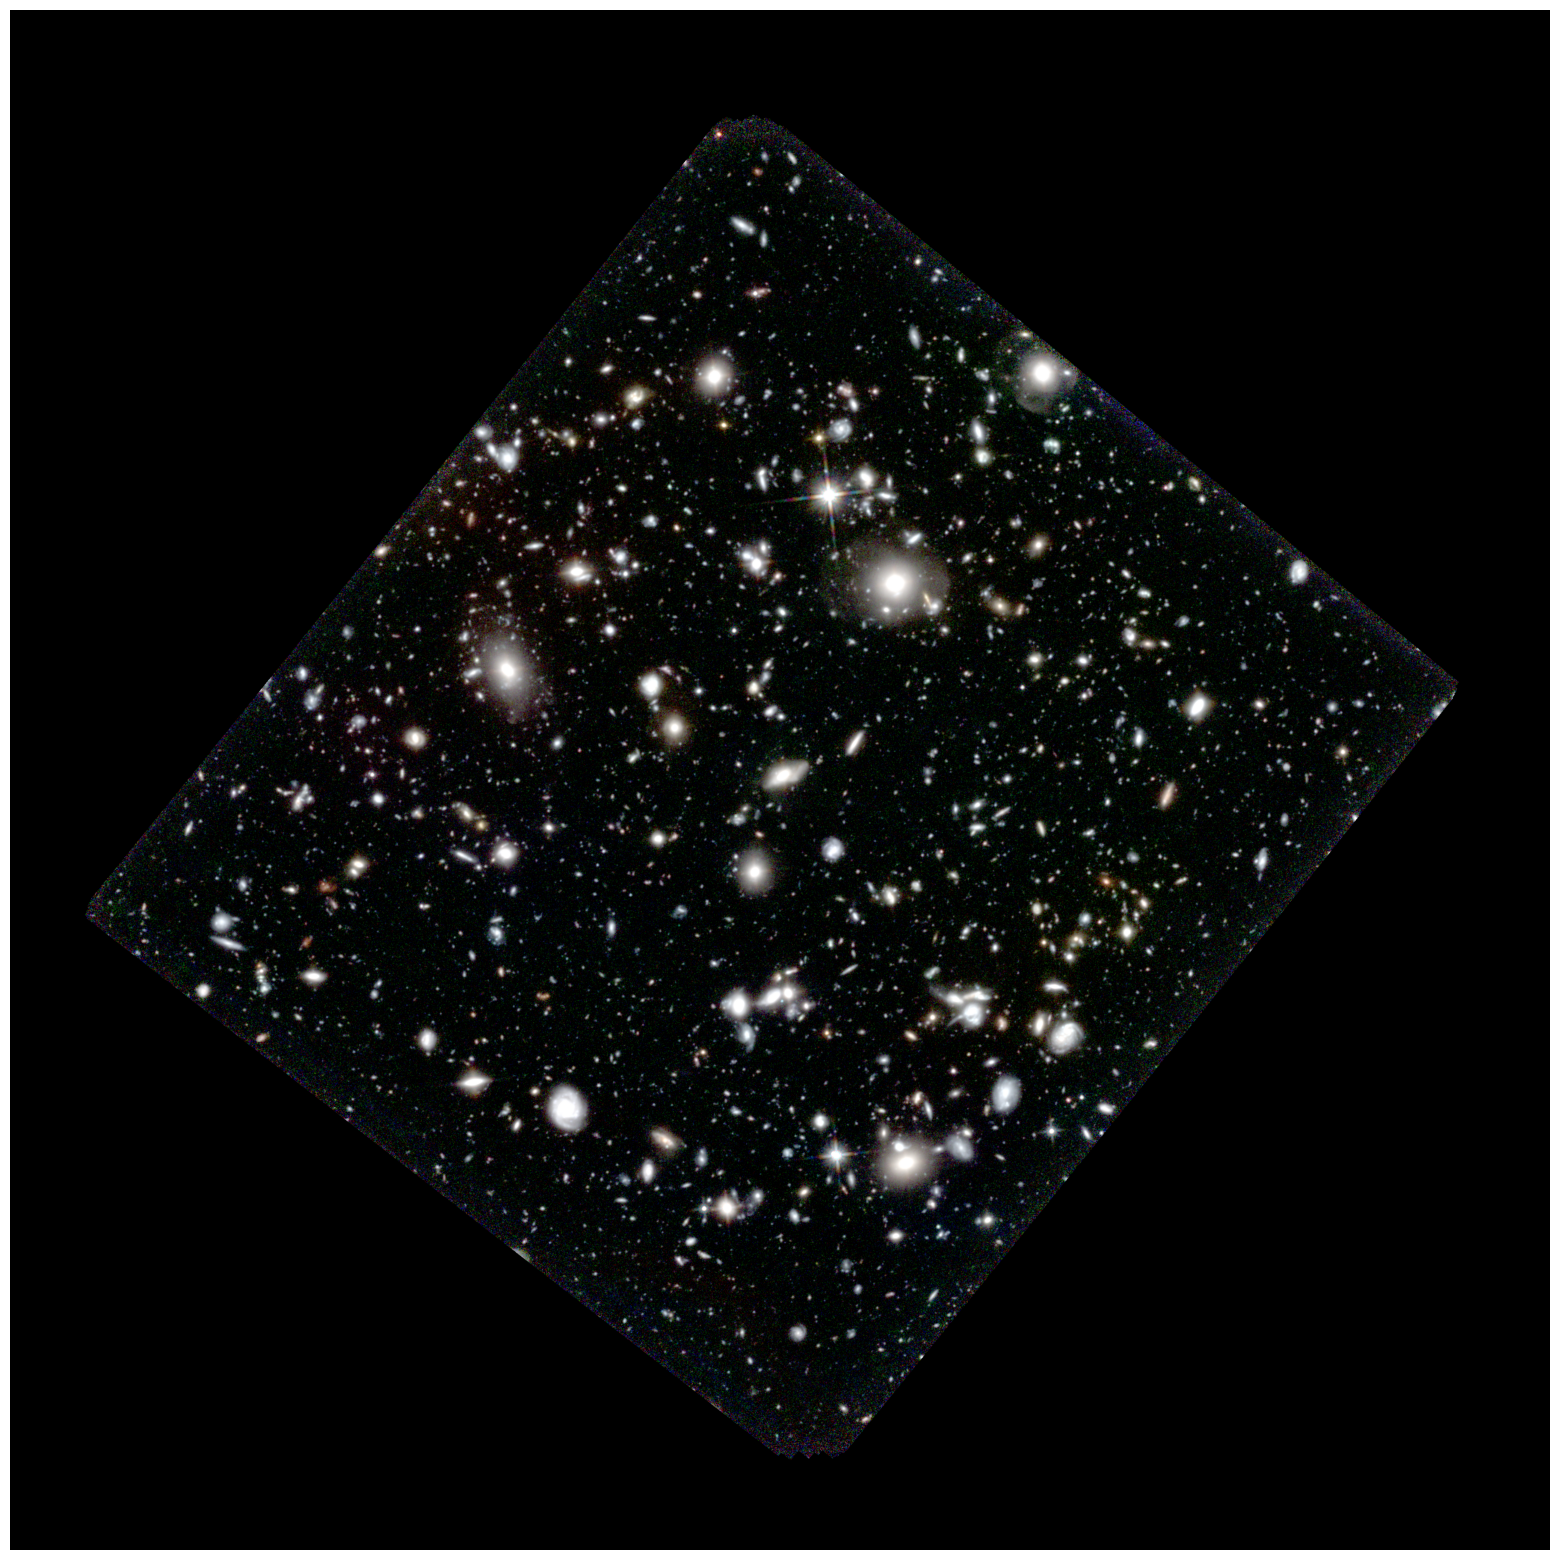

In [27]:
with fits.open('./hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits') as hdulist:
    f125w_band_image_data = hdulist[0].data
    f125w_band_image_data = f125w_band_image_data.byteswap().newbyteorder()

with fits.open('./hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits') as hdulist:
    f160w_band_image_data = hdulist[0].data
    f160w_band_image_data = f160w_band_image_data.byteswap().newbyteorder()

def rescale_image(image_data):
    pdata_tmp = image_data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m / 2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100.)
    pdata_tmp[pdata_tmp < vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)

    return pdata_tmp, vpmin, vpmax

rescaled_f160w_band_image_data, f160w_min, f160w_max = rescale_image(f160w_band_image_data)
rescaled_f125w_band_image_data, f125w_min, f125w_max = rescale_image(f125w_band_image_data)
rescaled_f105w_band_image_data, f105w_min, f105w_max = rescale_image(f105w_band_image_data)

rescaled_f160w_band_image_data[rescaled_f160w_band_image_data < f160w_min] = f160w_min
rescaled_f160w_band_image_data[rescaled_f160w_band_image_data > f160w_max] = f160w_max
rescaled_f125w_band_image_data[rescaled_f125w_band_image_data < f125w_min] = f125w_min
rescaled_f125w_band_image_data[rescaled_f125w_band_image_data > f125w_max] = f125w_max
rescaled_f105w_band_image_data[rescaled_f105w_band_image_data < f105w_min] = f105w_min
rescaled_f105w_band_image_data[rescaled_f105w_band_image_data > f105w_max] = f105w_max

color_false_image = np.zeros((rescaled_f160w_band_image_data.shape[0], rescaled_f105w_band_image_data.shape[1], 3))
color_false_image[:, :, 0] = (rescaled_f160w_band_image_data - f160w_min) / (f160w_max - f160w_min)
color_false_image[:, :, 1] = (rescaled_f125w_band_image_data - f125w_min) / (f125w_max - f125w_min)
color_false_image[:, :, 2] = (rescaled_f105w_band_image_data - f105w_min) / (f105w_max - f105w_min)

f, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.axis('off')
plt.imshow(color_false_image)
plt.savefig('colored_false_image.png', bbox_inches='tight', pad_inches=0, dpi=600)